# Exploratory analysis on article Titles
***

## Background

Determine the degree of consensus in contentious academic fields. 

Collect title, publication date and summaries from scholarly articles containing a certain keyword or keywords. Apply NLP models to this data to identify and categorise concepts in this field and determine statistical significance between opposing 'truths', if any. Ranking these groups according to weighted influence will prove the degree of consensus of various approaches in a given academic field.

To this end the academic_consensus model will search the abstracts of academic papers that contain the keyword "nutrition".

## Explore article Titles 
Load corpus_raw.csv into a DataFrame and use the 'titles' feature for exploratory analysis as overview on the dataset.
### Complete Bag Of Words (BOW) on Titles
Generate a complete BOW on all words that appear in all Titles, added together.
### Animated visualisation of BOW over time
An interactive, or simple animation, to show how the most frequent, and arguably most important words have evolved over time.

## Setup

### Packages and setup

In [1]:
# Common
import pandas as pd
import matplotlib.pyplot as plt

# Complete BOW requirements
from collections import Counter
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Animated BOW over time
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Workspace
from IPython.core.interactiveshell import InteractiveShell

In [15]:
# Set workspace
sns.set()
# Set output charackters to 110 (not 79)
pd.options.display.width = 110
# To give multiple cell output. Not just the last command.
InteractiveShell.ast_node_interactivity = 'last'

### Load and inspect corpus.csv

In [3]:
# Load corpus.csv as DataFrame with parsed date format
corpus = pd.read_csv('../data/interim/corpus_raw.csv', parse_dates=[0])

In [28]:
# Keyword 
keyword = 'nutrition'

In [4]:
# Inspect
corpus.info()
corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 3 columns):
publication_date    794 non-null datetime64[ns, UTC]
title               794 non-null object
conclusions         794 non-null object
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 18.7+ KB


,publication_date,title,conclusions
0,2014-10-21 00:00:00+00:00,Psychological Determinants of Consumer Accepta...,"['To the authors’ knowledge, this is the first..."
1,2015-03-13 00:00:00+00:00,Uncovering the Nutritional Landscape of Food,"['In this study, we have developed a unique co..."
2,2017-06-27 00:00:00+00:00,Developing and validating a scale to measure F...,['Food and nutrition literacy scale is a valid...
3,2017-05-18 00:00:00+00:00,Quality of nutrition services in primary healt...,"['The aim of the NNS, integrating nutrition se..."
4,2015-10-21 00:00:00+00:00,To See or Not to See: Do Front of Pack Nutriti...,['Our work strongly supports the idea that FOP...


## Bag Of Words of all article Titles

In [5]:
# Select 'titles' from DataFrame
titles = corpus['title']
titles_dict = dict(titles)

In [6]:
# Function to prepare text data
# tokenize, lowercase, minus numbers, minus stopwords, lemmatised

def text_cleaning(row_text):
    ''' Prepare row of text and convert to BOW'''
    tokens = word_tokenize(row_text)
    lower_tokens = [t.lower() for t in tokens]
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemmatized

In [7]:
# Create a list of all tokens
tokens_all =[]
for key, row_text in titles_dict.items():
    row_text_clean = text_cleaning(row_text)
    [tokens_all.append(word) for word in row_text_clean]
print('Done')

Done


Text(0.5, 1.0, 'Bag of Words for article titles with keyword "nutrition" with 30 most apearing words')

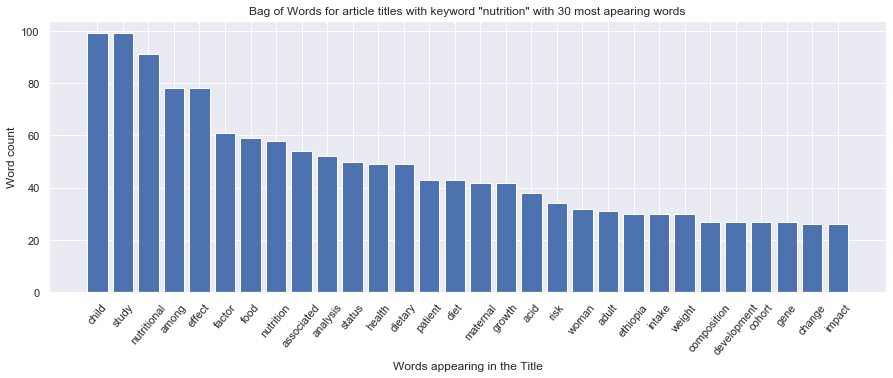

In [31]:
# Create Bag Of Words from all tokens
bow = Counter(tokens_all)
# Convert dictionary for ease of plotting
bow_dict = dict(bow.most_common(30))
# Plot
plt.figure(figsize=(15,5))
plt.bar(bow_dict.keys(), bow_dict.values())
plt.xticks(rotation=50);
plt.xlabel('Words appearing in the Title')
plt.ylabel('Word count')
plt.title('Bag of Words for article titles with keyword "{}" with 30 most apearing words'.format(keyword))

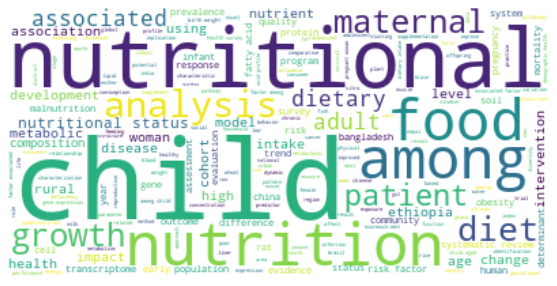

In [9]:
# Create one continuous string of words to use 'wordcloud'
tokens_all_str = ''
for word in tokens_all:
    tokens_all_str += ' ' + word
    
# add redundant stopwords
stopwords_bow = set(STOPWORDS)
stopwords_bow.update(['effect', 'study'])
wordcloud = WordCloud(background_color='white', stopwords=stopwords_bow).generate(tokens_all_str)

# Display the generated image
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualised BOW over time

Create a document-term matrix from the 'title' feature.

In [10]:
# Convert all 'title' text to a list of documents
text_title = list(corpus['title'])

In [11]:
# Use CountVectorizer on all titles
vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w+\\b')
# Convert to document-term matrix
text_dtm = vect.fit_transform(text_title)

#(?u)\\b\\w\\w+\\b  - regex standard
#\\b[^\\d\\W]+\\b   - regex to exclude digits everywhere
# co2|[^\\d\\W]+    - regex to exclude digits except "co2"

In [12]:
# Convert to dataframe
df_title = pd.DataFrame(text_dtm.toarray(), columns=vect.get_feature_names())
# Add the published date column set it as index
df_title['publication_date'] = corpus['publication_date']
df_title = df_title.set_index(['publication_date'])


Explore published articles per year.

In [13]:
# Create a new dataframe with a temporary column
df_article_year = df_title.copy()
df_article_year['###counter###'] = 1
# Groupby year
df_article_year = df_article_year.resample('Y').sum()
# Extract year only from publication_date
df_article_year['year_of_date'] = df_article_year.index
df_article_year['year_of_date'] = pd.to_datetime(df_article_year['year_of_date']).dt.year
# Reset index and select counter only
article_year = df_article_year.set_index(['year_of_date'])['###counter###']

Text(0.5, 1.0, 'Number of articles with Titles containing keyword "nutrition".')

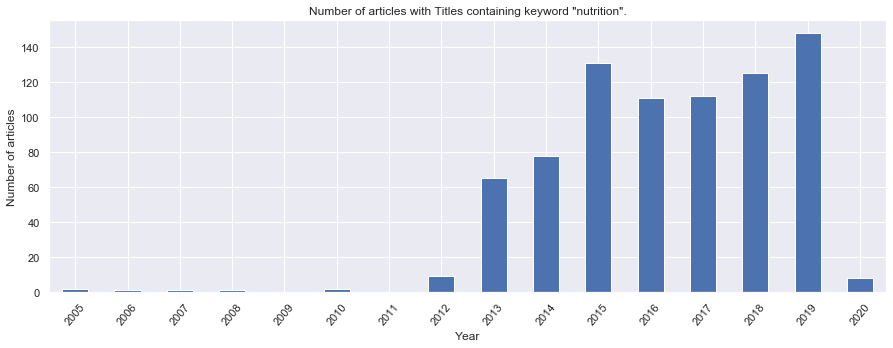

In [34]:
# Bar plot

plt.figure(figsize=(15,5))
article_year.plot(kind='bar')
plt.xticks(rotation=50);
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles with Titles containing keyword "{}".'.format(keyword))

In [ ]:
# Group by year
df_title = df_title.resample('Y').sum()

In [154]:
# Order df_title features from most occuring words to least

# Get index of top 50 most occuring features
index_most_features = df_title.resample('100Y').sum().iloc[1].sort_values(ascending=False).keys()
# Convert to list
index_most_features = list(index_most_features)
# Re-order columns and select only top 50 words
df_title = df_title[index_most_features[:50]]

In [172]:
df_title['2015'].values
#.plot(kind='bar')
#df_title.plot(kind='bar')
#df_title.resample('100Y').sum().iloc[1].sort_values(ascending=False)

array([[12, 12,  2,  7,  5, 10,  8,  7,  6,  5,  8, 11, 15,  6,  7,  6,
         3,  4,  4,  5,  6,  7,  3,  2,  5,  2,  5,  1,  6,  4,  2,  7,
         3,  2,  5,  6,  2,  4,  2,  2,  5,  3,  2,  2,  2,  2,  6,  5,
         3,  2]], dtype=int64)

In [168]:
from bokeh.io import output_file, show
from bokeh.plotting import figure

### Clean 'title'. No, mess around with spacy

In [5]:
corpus['title'][0]

'Psychological Determinants of Consumer Acceptance of Personalised Nutrition in 9 European Countries'

In [70]:
b = corpus['conclusions'][0]

In [67]:
type(a)
a

0    ['To the authors’ knowledge, this is the first...
1    ['In this study, we have developed a unique co...
Name: conclusions, dtype: object

In [7]:
nlp = spacy.load('en_core_web_sm')

In [78]:
parsed_row = nlp(b)

In [80]:

token_attr = [(token.orth_, 
               token.lemma_,
               token.is_stop, 
               token.is_punct, 
               token.is_space, 
               token.like_num, 
               token.is_oov) for token in parsed_row]

df = pd.DataFrame(token_attr, columns=['text', 'lemma', 'stop', 'punct', 'space', 'num', 'oov'])


In [81]:
df

,text,lemma,stop,punct,space,num,oov
0,[,[,False,True,False,False,True
1,',',False,True,False,False,True
2,To,to,True,False,False,False,True
3,the,the,True,False,False,False,True
4,authors,author,False,False,False,False,True
...,...,...,...,...,...,...,...
211,of,of,True,False,False,False,True
212,Control,Control,False,False,False,False,True
213,.,.,False,True,False,False,True
214,',',False,True,False,False,True


In [60]:
df['text']

0            [
1            '
2           To
3          the
4      authors
        ...   
211         of
212    Control
213          .
214          '
215          ]
Name: text, Length: 216, dtype: object